# DELE CA1 Part B > CIFAR-10

## Import General Dependencies

In [10]:
# Data Manipulation Dependencies
import numpy as np
import pandas as pd

# Graphing Dependencies
import matplotlib.pyplot as plt
import seaborn as sb

# General Machine Learning Dependencies
from sklearn.model_selection import *
from sklearn.metrics import *

# Deep Learning Dependencies
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.image import rgb_to_grayscale

## Import Data

In [2]:
def load_data(train_only = False):
    from tensorflow.keras.datasets import cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    if train_only:
        return X_train, y_train
    return X_train, y_train, X_test, y_test

In [3]:
def get_labels():
    return [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'
    ]

## Exploratory Data Analysis

In [6]:
def print_data_shapes():
    X_train, y_train, X_test, y_test = load_data()

    print('X_train shape:\t', X_train.shape)
    print('y_train shape:\t', y_train.shape)
    print('X_test shape:\t', X_test.shape)
    print('y_test shape:\t', y_test.shape)

print_data_shapes()

X_train shape:	 (50000, 32, 32, 3)
y_train shape:	 (50000, 1)
X_test shape:	 (10000, 32, 32, 3)
y_test shape:	 (10000, 1)


In [5]:
def print_missing_values():
    X_train, y_train, X_test, y_test = load_data()

    print('X_train missing:', np.isnan(X_train).sum())
    print('y_train missing:', np.isnan(y_train).sum())
    print('X_test missing: ', np.isnan(X_test).sum())
    print('y_test missing: ', np.isnan(y_test).sum())

print_missing_values()

X_train missing: 0
y_train missing: 0
X_test missing:  0
y_test missing:  0


In [11]:
def print_class_distribution():
    _, y_train, _, y_test = load_data()
    y_train_tmp = y_train.flatten()
    y_test_tmp = y_test.flatten()
    print(pd.Series(y_train_tmp.flatten(), name='class distribution (train)').groupby(pd.Series(y_train_tmp)).count())
    print(pd.Series(y_test_tmp.flatten(), name='class distribution (test)').groupby(pd.Series(y_test_tmp)).count())

print_class_distribution()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: class distribution (train), dtype: int64
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: class distribution (test), dtype: int64


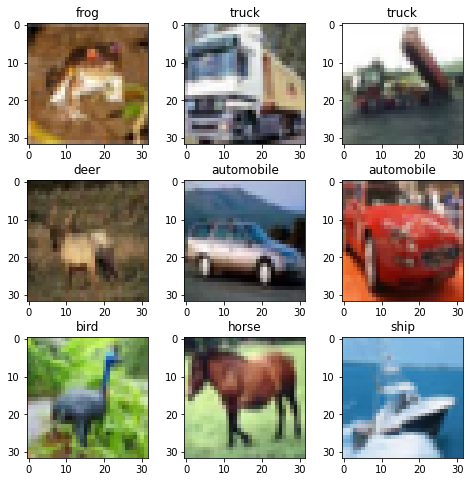

In [ ]:
def plot_samples(data_load_fn=load_data, **kwargs):
    X_train, y_train = data_load_fn(train_only=True)
    y_tmp = y_train.flatten()
    labels = get_labels()
    fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(9):
        current_ax = ax[i // 3, i % 3]
        current_ax.imshow(X_train[i], **kwargs)
        current_ax.set_title(labels[y_tmp[i]])
    plt.subplots_adjust(hspace=0.3)

plot_samples()

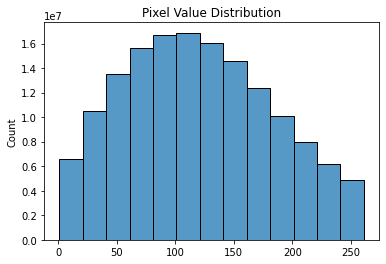

In [4]:
# Depicts the distribution of all the pixel values (excluding 0 and 255),
#   to check for general image contrast
def plot_pixel_value_distribution(data_load_fn=load_data):
    X_train, _ = data_load_fn(train_only=True)

    ax = sb.histplot(x=X_train[(X_train > 0) & (X_train < 255)].flatten(), binwidth=20)
    ax.set_title('Pixel Value Distribution')

plot_pixel_value_distribution()

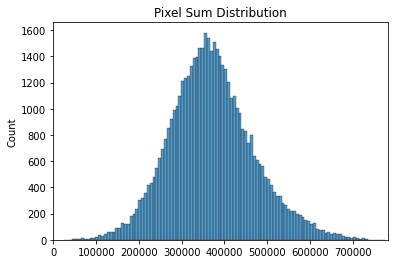

In [15]:
# Depicts the distribution of the image pixel sums,
#   a simple check for adversarial samples (all black or all white)
#
# Since there are no samples at either end of the spectrum,
#   there aren't any of these adversarial samples
def plot_pixel_sum_distribution():
    X_train, _ = load_data(train_only=True)

    X_tmp = X_train.reshape(-1, 32 * 32 * 3)

    ax = sb.histplot(x=X_tmp.sum(axis=1))
    ax.set_title('Pixel Sum Distribution')
    ax.set_xlim((0, 255 * 32 * 32 * 3))

plot_pixel_sum_distribution()

In [4]:
def plot_diagnostics(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='test loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='test acc')
    plt.legend()
    plt.show()

## Data Pre-Processing

In [5]:
def preprocess_data(X_train, y_train, X_test, y_test):
    # Normalise the data
    X_train = X_train.astype(float) / 255.0
    X_test = X_test.astype(float) / 255.0

    # Increase the contrast of the images
    X_train[(X_train > 100) & (X_train < 128)] -= 30
    X_train[(X_train >= 128) & (X_train < 156)] += 30

    X_test[(X_test > 100) & (X_test < 128)] -= 30
    X_test[(X_test >= 128) & (X_test < 156)] += 30

    # One-Hot encode the target labels
    y_train = to_categorical(y_train.flatten(), 10)
    y_test = to_categorical(y_test.flatten(), 10)
    
    return X_train, y_train, X_test, y_test

In [6]:
def load_preprocessed_data(train_only = False):
    X_train, y_train, X_test, y_test = preprocess_data(*load_data())

    if train_only:
        return X_train, y_train
    return X_train, y_train, X_test, y_test

In [7]:
def load_grayscale_data(train_only=False):
    X_train, y_train, X_test, y_test = load_data()

    X_train = rgb_to_grayscale(X_train).numpy().reshape(-1, 32, 32)
    X_test = rgb_to_grayscale(X_test).numpy().reshape(-1, 32, 32)

    if train_only:
        return X_train, y_train
    return X_train, y_train, X_test, y_test

In [8]:
def load_preprocessed_grayscale_data(train_only=False):
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    X_train = rgb_to_grayscale(X_train).numpy().reshape(-1, 32, 32, 1)
    X_test = rgb_to_grayscale(X_test).numpy().reshape(-1, 32, 32, 1)

    if train_only:
        return X_train, y_train
    return X_train, y_train, X_test, y_test

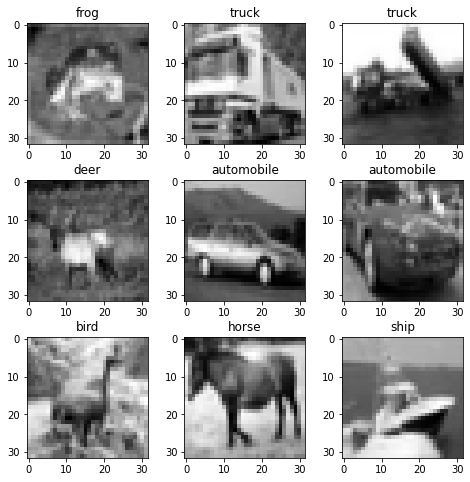

In [ ]:
plot_samples(data_load_fn=load_grayscale_data, cmap='gray')

## Baseline Models

Epoch 1/5
400/400 - 2s - loss: 2.1931 - accuracy: 0.2537 - val_loss: 2.0467 - val_accuracy: 0.3211 - 2s/epoch - 5ms/step
Epoch 2/5
400/400 - 1s - loss: 2.0564 - accuracy: 0.3022 - val_loss: 2.0674 - val_accuracy: 0.2944 - 1s/epoch - 4ms/step
Epoch 3/5
400/400 - 1s - loss: 2.0264 - accuracy: 0.3124 - val_loss: 1.8798 - val_accuracy: 0.3326 - 1s/epoch - 4ms/step
Epoch 4/5
400/400 - 1s - loss: 2.0023 - accuracy: 0.3243 - val_loss: 2.0463 - val_accuracy: 0.3186 - 1s/epoch - 3ms/step
Epoch 5/5
400/400 - 1s - loss: 1.9889 - accuracy: 0.3280 - val_loss: 1.8905 - val_accuracy: 0.3469 - 1s/epoch - 4ms/step


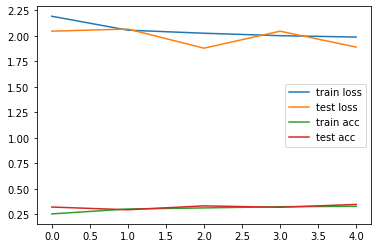

In [22]:
# Simple Dense Neural Network
def baseline_1():
    X_train, y_train = load_preprocessed_data(train_only=True)
    dnn = Sequential(layers=[
        InputLayer(input_shape=(32, 32, 3)),
        Flatten(),
        Dense(units=10, activation='softmax')
    ])
    dnn.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = dnn.fit(x=X_train, y=y_train, epochs=5, batch_size=100, validation_split=0.2, verbose=2)
    plot_diagnostics(history)

baseline_1()

Epoch 1/5
400/400 - 15s - loss: 2.0338 - accuracy: 0.2724 - val_loss: 1.8009 - val_accuracy: 0.3701 - 15s/epoch - 39ms/step
Epoch 2/5
400/400 - 2s - loss: 1.6856 - accuracy: 0.4124 - val_loss: 1.6717 - val_accuracy: 0.4253 - 2s/epoch - 5ms/step
Epoch 3/5
400/400 - 2s - loss: 1.5675 - accuracy: 0.4569 - val_loss: 1.5902 - val_accuracy: 0.4509 - 2s/epoch - 5ms/step
Epoch 4/5
400/400 - 2s - loss: 1.5062 - accuracy: 0.4775 - val_loss: 1.5741 - val_accuracy: 0.4541 - 2s/epoch - 5ms/step
Epoch 5/5
400/400 - 2s - loss: 1.4650 - accuracy: 0.4932 - val_loss: 1.5648 - val_accuracy: 0.4589 - 2s/epoch - 5ms/step


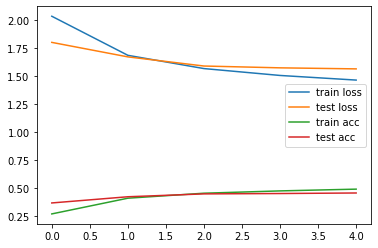

In [10]:
# Simple Convolutional Neural Network
def baseline_2():
    X_train, y_train = load_preprocessed_data(train_only=True)
    cnn = Sequential(layers=[
        InputLayer(input_shape=(32, 32, 3)),
        Conv2D(filters=3, kernel_size=3),
        Flatten(),
        Dense(units=30, activation='relu'),
        Dense(units=10, activation='softmax')
    ])
    cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = cnn.fit(x=X_train, y=y_train, epochs=5, batch_size=100, validation_split=0.2, verbose=2)
    plot_diagnostics(history)

baseline_2()

Epoch 1/5
400/400 - 4s - loss: 1.6476 - accuracy: 0.4124 - val_loss: 1.6316 - val_accuracy: 0.4343 - 4s/epoch - 10ms/step
Epoch 2/5
400/400 - 3s - loss: 1.3380 - accuracy: 0.5213 - val_loss: 1.5536 - val_accuracy: 0.4532 - 3s/epoch - 7ms/step
Epoch 3/5
400/400 - 3s - loss: 1.2270 - accuracy: 0.5611 - val_loss: 1.5213 - val_accuracy: 0.4675 - 3s/epoch - 7ms/step
Epoch 4/5
400/400 - 3s - loss: 1.1492 - accuracy: 0.5885 - val_loss: 1.3865 - val_accuracy: 0.5208 - 3s/epoch - 7ms/step
Epoch 5/5
400/400 - 3s - loss: 1.0880 - accuracy: 0.6112 - val_loss: 1.3095 - val_accuracy: 0.5417 - 3s/epoch - 7ms/step


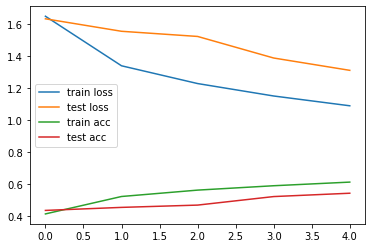

In [11]:
# Convolutional Neural Network with Logical Architecture
def baseline_3():
    X_train, y_train = load_preprocessed_data(train_only=True)
    cnn = Sequential(layers=[
        InputLayer(input_shape=(32, 32, 3)),
        Conv2D(filters=8, kernel_size=3, activation='relu'),
        MaxPool2D(pool_size=2, strides=2),
        Conv2D(filters=10, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=16, activation='relu'),
        Dense(units=10, activation='softmax')
    ])
    cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = cnn.fit(x=X_train, y=y_train, epochs=5, batch_size=100, validation_split=0.2, verbose=2)
    plot_diagnostics(history)

baseline_3()

## Hyper-Parameter Tuning

### Classic Deep Convolutional Neural Network

1563/1563 [==============================] - 9s 6ms/step - loss: 0.5845 - accuracy: 0.8045
[0.5845184922218323, 0.8044999837875366]
313/313 [==============================] - 2s 6ms/step - loss: 0.7530 - accuracy: 0.7383
[0.7530091404914856, 0.7383000254631042]


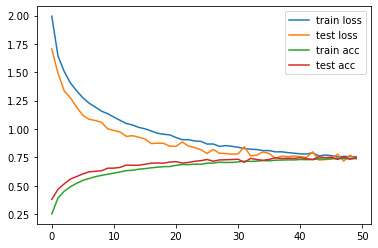

In [ ]:
def hyper_tune_1():
    X_train, y_train, X_test, y_test = load_preprocessed_data()
    
    model = Sequential(layers=[
        Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Dropout(0.25),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Dropout(0.3),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(0.15),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_split=0.2, batch_size=128, epochs=50, verbose=0)

    print(model.evaluate(X_train, y_train))
    print(model.evaluate(X_test, y_test))

    plot_diagnostics(history)

hyper_tune_1()

1563/1563 [==============================] - 9s 6ms/step - loss: 0.3449 - accuracy: 0.8856
[0.34489527344703674, 0.8856199979782104]
313/313 [==============================] - 2s 6ms/step - loss: 0.6502 - accuracy: 0.7829
[0.6502257585525513, 0.7828999757766724]


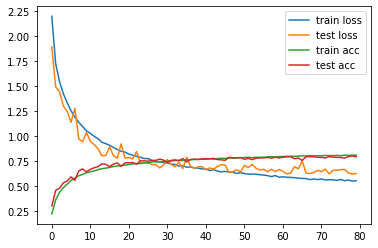

In [ ]:
# Changed the number of strides of the convolutional layer
# Added batch normalization layers
def hyper_tune_2():
    X_train, y_train, X_test, y_test = load_preprocessed_data()
    
    model = Sequential()
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), strides=2, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_split=0.2, batch_size=128, epochs=80, verbose=0)

    print(model.evaluate(X_train, y_train))
    print(model.evaluate(X_test, y_test))
    
    plot_diagnostics(history)

hyper_tune_2()

1563/1563 [==============================] - 10s 6ms/step - loss: 0.2234 - accuracy: 0.9400
[0.22337836027145386, 0.9399600028991699]
313/313 [==============================] - 2s 6ms/step - loss: 0.8448 - accuracy: 0.7657
[0.8448024392127991, 0.7656999826431274]


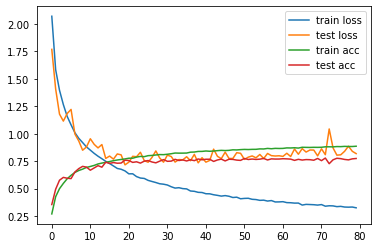

In [ ]:
# Increased the number of epochs
def hyper_tune_3():
    X_train, y_train, X_test, y_test = load_preprocessed_data()
    
    model = Sequential()
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_split=0.2, batch_size=128, epochs=80, verbose=0)

    print(model.evaluate(X_train, y_train))
    print(model.evaluate(X_test, y_test))
    
    plot_diagnostics(history)

hyper_tune_3()

1563/1563 [==============================] - 11s 7ms/step - loss: 0.2854 - accuracy: 0.9092
[0.2853948175907135, 0.9092400074005127]
313/313 [==============================] - 2s 7ms/step - loss: 0.6292 - accuracy: 0.7925
[0.6292394399642944, 0.7925000190734863]


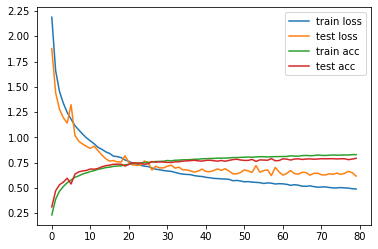

In [ ]:
# Increased the number of filters
def hyper_tune_4():
    X_train, y_train, X_test, y_test = load_preprocessed_data()
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), strides=2, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), strides=2, activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_split=0.2, batch_size=128, epochs=80, verbose=0)
    
    print(model.evaluate(X_train, y_train))
    print(model.evaluate(X_test, y_test))
    
    plot_diagnostics(history)

hyper_tune_4()

### Deep Fully Convolutional Neural Network

In [9]:
# A convolutional block, inspired by VGG blocks
def Conv_Block(num_filters: int, activation='relu', kernel_size=3, drop_rate=0.5):
    blk = Sequential()
    blk.add(Conv2D(
        filters=num_filters, padding='same', kernel_size=kernel_size,
        kernel_initializer='he_normal', kernel_regularizer=l2(1e-5), activation=activation
    ))
    blk.add(Conv2D(
        filters=num_filters, padding='same', kernel_size=kernel_size, strides=2,
        kernel_initializer='he_normal', kernel_regularizer=l2(1e-5), activation=activation
    ))
    blk.add(BatchNormalization())
    blk.add(Dropout(drop_rate))
    return blk

In [ ]:
# Define the general model architecture,
#   with consists of only convolutional layers
def define_model(conv_arch, optimizer):
    model = Sequential(layers=[
        InputLayer(input_shape=(32, 32, 3))
    ])
    for (filters, drop_rate) in conv_arch:
        model.add(Conv_Block(filters, drop_rate=drop_rate))
    
    model.add(Conv2D(filters=10, kernel_size=1, activation='sigmoid'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# 2 convolutional blocks
# Default Adam optimizer
def model_1():
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    model = define_model(
        conv_arch = [(32, 0.3), (64, 0.3)],
        optimizer = 'adam'
    )

    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128)

    plot_diagnostics(history)

Epoch 1/50
313/313 [==============================] - 20s 26ms/step - loss: 2.0820 - accuracy: 0.2506 - val_loss: 1.9542 - val_accuracy: 0.3056
Epoch 2/50
313/313 [==============================] - 7s 24ms/step - loss: 1.8420 - accuracy: 0.3620 - val_loss: 1.7666 - val_accuracy: 0.3811
Epoch 3/50
313/313 [==============================] - 7s 24ms/step - loss: 1.7116 - accuracy: 0.4176 - val_loss: 1.7542 - val_accuracy: 0.3377
Epoch 4/50
313/313 [==============================] - 7s 24ms/step - loss: 1.6141 - accuracy: 0.4560 - val_loss: 1.5916 - val_accuracy: 0.4219
Epoch 5/50
313/313 [==============================] - 7s 24ms/step - loss: 1.5338 - accuracy: 0.4828 - val_loss: 1.5062 - val_accuracy: 0.4886
Epoch 6/50
313/313 [==============================] - 7s 23ms/step - loss: 1.4634 - accuracy: 0.5128 - val_loss: 1.4283 - val_accuracy: 0.4880
Epoch 7/50
313/313 [==============================] - 7s 23ms/step - loss: 1.4020 - accuracy: 0.5290 - val_loss: 1.4491 - val_accuracy: 0.475

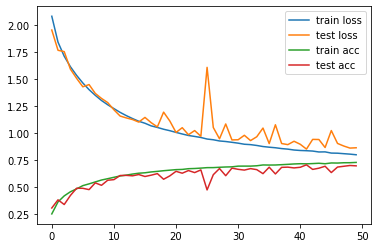

In [ ]:
model_1()

In [ ]:
# Added 1 more convolutional block
# Changed optimizer to RMS propagation
def model_2():
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    model = define_model(
        conv_arch = [(16, 0.2), (32, 0.3), (64, 0.4)],
        optimizer = RMSprop(learning_rate=0.001,decay=1e-6)
    )

    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=50)
                        
    plot_diagnostics(history)

Epoch 1/50
800/800 [==============================] - 14s 15ms/step - loss: 1.9110 - accuracy: 0.3081 - val_loss: 1.7404 - val_accuracy: 0.3782
Epoch 2/50
800/800 [==============================] - 11s 14ms/step - loss: 1.6048 - accuracy: 0.4230 - val_loss: 1.4717 - val_accuracy: 0.4641
Epoch 3/50
800/800 [==============================] - 12s 14ms/step - loss: 1.4436 - accuracy: 0.4834 - val_loss: 1.3724 - val_accuracy: 0.4860
Epoch 4/50
800/800 [==============================] - 11s 14ms/step - loss: 1.3336 - accuracy: 0.5221 - val_loss: 1.2675 - val_accuracy: 0.5428
Epoch 5/50
800/800 [==============================] - 12s 15ms/step - loss: 1.2580 - accuracy: 0.5552 - val_loss: 1.2124 - val_accuracy: 0.5674
Epoch 6/50
800/800 [==============================] - 11s 14ms/step - loss: 1.1941 - accuracy: 0.5785 - val_loss: 1.3182 - val_accuracy: 0.5282
Epoch 7/50
800/800 [==============================] - 11s 14ms/step - loss: 1.1489 - accuracy: 0.5931 - val_loss: 1.0968 - val_accuracy:

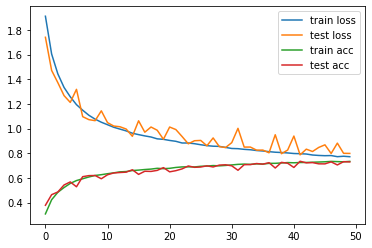

In [ ]:
model_2()

In [ ]:
# Added 1 more convolution block
# Changed optimizer to SGD,
#   with a decaying learning rate
def model_3():
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    model = define_model(
        conv_arch = [(16, 0.2), (32, 0.3), (64, 0.4), (64, 0.3)],
        optimizer = SGD(learning_rate=0.01, momentum=0.7)
    )

    def exp_decay(epoch):
        from math import exp
        initial_lr = 0.01
        k = 0.01
        return initial_lr * exp(-k * epoch)

    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[LearningRateScheduler(exp_decay)])

    plot_diagnostics(history)

Epoch 1/50
625/625 [==============================] - 12s 16ms/step - loss: 2.1966 - accuracy: 0.1686 - val_loss: 2.1338 - val_accuracy: 0.1997 - lr: 0.0100
Epoch 2/50
625/625 [==============================] - 10s 15ms/step - loss: 1.9415 - accuracy: 0.2666 - val_loss: 1.9886 - val_accuracy: 0.2447 - lr: 0.0099
Epoch 3/50
625/625 [==============================] - 9s 15ms/step - loss: 1.7844 - accuracy: 0.3252 - val_loss: 1.7613 - val_accuracy: 0.3259 - lr: 0.0098
Epoch 4/50
625/625 [==============================] - 9s 15ms/step - loss: 1.6883 - accuracy: 0.3657 - val_loss: 1.6281 - val_accuracy: 0.3897 - lr: 0.0097
Epoch 5/50
625/625 [==============================] - 9s 15ms/step - loss: 1.6204 - accuracy: 0.3916 - val_loss: 1.5880 - val_accuracy: 0.4057 - lr: 0.0096
Epoch 6/50
625/625 [==============================] - 9s 15ms/step - loss: 1.5637 - accuracy: 0.4148 - val_loss: 1.6001 - val_accuracy: 0.3999 - lr: 0.0095
Epoch 7/50
625/625 [==============================] - 9s 15ms/

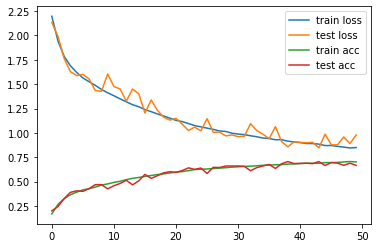

In [ ]:
model_3()

In [8]:
# Changed global average pooling layer to global max pooling
def define_model_2(conv_arch, optimizer):
    model = Sequential(layers=[
        InputLayer(input_shape=(32, 32, 3))
    ])
    for (filters, drop) in conv_arch:
        model.add(Conv_Block(filters, drop_rate=drop))
    model.add(Conv2D(filters=10, kernel_size=1, activation='sigmoid'))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(units=10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Used the new model stencil
#   with a higher initial learning rate
#
# Added 1 more convolutional block
def model_4():
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    model = define_model_2(
        conv_arch = [(16, 0.2), (32, 0.3), (64, 0.4), (64, 0.3)],
        optimizer = SGD(learning_rate=0.1, momentum=0.7)
    )

    def exp_decay(epoch):
        from math import exp
        initial_lr = 0.1
        k = 0.01
        return initial_lr * exp(-k * epoch)

    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[LearningRateScheduler(exp_decay)])

    plot_diagnostics(history)

Epoch 1/50
625/625 [==============================] - 12s 16ms/step - loss: 1.8678 - accuracy: 0.2978 - val_loss: 2.2150 - val_accuracy: 0.2849 - lr: 0.1000
Epoch 2/50
625/625 [==============================] - 10s 15ms/step - loss: 1.5651 - accuracy: 0.4238 - val_loss: 1.4451 - val_accuracy: 0.4707 - lr: 0.0990
Epoch 3/50
625/625 [==============================] - 9s 15ms/step - loss: 1.4298 - accuracy: 0.4838 - val_loss: 1.3088 - val_accuracy: 0.5357 - lr: 0.0980
Epoch 4/50
625/625 [==============================] - 9s 15ms/step - loss: 1.3415 - accuracy: 0.5170 - val_loss: 1.2349 - val_accuracy: 0.5596 - lr: 0.0970
Epoch 5/50
625/625 [==============================] - 9s 15ms/step - loss: 1.2718 - accuracy: 0.5462 - val_loss: 1.3568 - val_accuracy: 0.5271 - lr: 0.0961
Epoch 6/50
625/625 [==============================] - 9s 15ms/step - loss: 1.2069 - accuracy: 0.5703 - val_loss: 1.4710 - val_accuracy: 0.4885 - lr: 0.0951
Epoch 7/50
625/625 [==============================] - 9s 15ms/

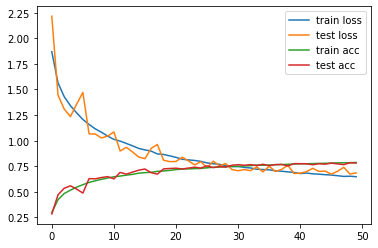

In [ ]:
model_4()

### Grayscale Alternative

In [10]:
def define_model_3(conv_arch, optimizer):
    model = Sequential(layers=[
        InputLayer(input_shape=(32, 32, 1))
    ])
    for (filters, drop) in conv_arch:
        model.add(Conv_Block(filters, drop_rate=drop))
    model.add(Conv2D(filters=10, kernel_size=1, activation='sigmoid'))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(units=10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Same architecture as model_4
#   but designed for single-channel image data
def model_4_gray():
    X_train, y_train, X_test, y_test = load_preprocessed_grayscale_data()

    model = define_model_3(
        conv_arch = [(16, 0.2), (32, 0.3), (64, 0.4), (64, 0.3)],
        optimizer = SGD(learning_rate=0.1, momentum=0.7)
    )

    def exp_decay(epoch):
        from math import exp
        initial_lr = 0.1
        k = 0.01
        return initial_lr * exp(-k * epoch)

    decaying_lr = LearningRateScheduler(exp_decay)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[decaying_lr])

    plot_diagnostics(history)

Epoch 1/50
782/782 [==============================] - 14s 17ms/step - loss: 1.9166 - accuracy: 0.2907 - val_loss: 2.2855 - val_accuracy: 0.2170 - lr: 0.1000
Epoch 2/50
782/782 [==============================] - 13s 17ms/step - loss: 1.6014 - accuracy: 0.4188 - val_loss: 1.5496 - val_accuracy: 0.4549 - lr: 0.0990
Epoch 3/50
782/782 [==============================] - 12s 16ms/step - loss: 1.4318 - accuracy: 0.4899 - val_loss: 1.8693 - val_accuracy: 0.3842 - lr: 0.0980
Epoch 4/50
782/782 [==============================] - 12s 16ms/step - loss: 1.3178 - accuracy: 0.5380 - val_loss: 1.2705 - val_accuracy: 0.5574 - lr: 0.0970
Epoch 5/50
782/782 [==============================] - 13s 16ms/step - loss: 1.2356 - accuracy: 0.5675 - val_loss: 1.4235 - val_accuracy: 0.5165 - lr: 0.0961
Epoch 6/50
782/782 [==============================] - 13s 17ms/step - loss: 1.1611 - accuracy: 0.5956 - val_loss: 1.3719 - val_accuracy: 0.5265 - lr: 0.0951
Epoch 7/50
782/782 [==============================] - 13s 

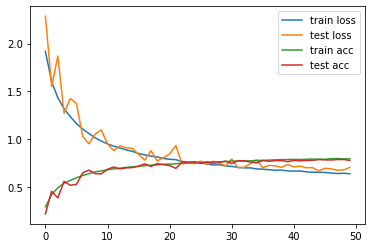

In [ ]:
model_4_gray()

### Data Augmentation

In [ ]:
# Used data augmentation to attempt to boost the performance of model_4
def model_5():    
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    model = define_model_2(
        conv_arch = [(16, 0.2), (32, 0.3), (64, 0.4), (64, 0.3)],
        optimizer = SGD(learning_rate=0.1, momentum=0.7)
    )

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.2
    )

    datagen.fit(X_train)
    
    batch_size = 40

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size, subset='training'),
        validation_data=datagen.flow(X_train, y_train, batch_size=batch_size // 4, subset='validation'),
        epochs=80
    )

    plot_diagnostics(history)

Epoch 1/80
1000/1000 [==============================] - 53s 43ms/step - loss: 1.8827 - accuracy: 0.2986 - val_loss: 2.1887 - val_accuracy: 0.2656
Epoch 2/80
1000/1000 [==============================] - 43s 43ms/step - loss: 1.6240 - accuracy: 0.4071 - val_loss: 1.5779 - val_accuracy: 0.4141
Epoch 3/80
1000/1000 [==============================] - 43s 43ms/step - loss: 1.5267 - accuracy: 0.4464 - val_loss: 1.6621 - val_accuracy: 0.4247
Epoch 4/80
1000/1000 [==============================] - 43s 43ms/step - loss: 1.4467 - accuracy: 0.4810 - val_loss: 1.3377 - val_accuracy: 0.5190
Epoch 5/80
1000/1000 [==============================] - 43s 43ms/step - loss: 1.3867 - accuracy: 0.5038 - val_loss: 1.3771 - val_accuracy: 0.5101
Epoch 6/80
1000/1000 [==============================] - 43s 43ms/step - loss: 1.3334 - accuracy: 0.5241 - val_loss: 1.2620 - val_accuracy: 0.5453
Epoch 7/80
1000/1000 [==============================] - 43s 43ms/step - loss: 1.2990 - accuracy: 0.5375 - val_loss: 1.2221 -

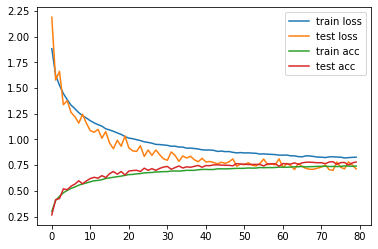

In [ ]:
model_5()

## Final Model

In [7]:
def Conv_Block_(num_filters: int, activation='relu', kernel_size=3, drop_rate=0.5):
    blk = Sequential()
    blk.add(Conv2D(
        filters=num_filters, padding='same', kernel_size=kernel_size,
        kernel_initializer='he_normal', kernel_regularizer=l2(1e-5), activation=activation
    ))
    blk.add(Dropout(drop_rate))
    blk.add(Conv2D(
        filters=num_filters, padding='same', kernel_size=kernel_size,
        kernel_initializer='he_normal', kernel_regularizer=l2(1e-5), activation=activation
    ))
    blk.add(Dropout(drop_rate))
    blk.add(Conv2D(
        filters=num_filters, padding='same', kernel_size=kernel_size, strides=2,
        kernel_initializer='he_normal', kernel_regularizer=l2(1e-5), activation=activation
    ))
    blk.add(Dropout(drop_rate))
    blk.add(BatchNormalization())
    return blk

In [8]:
def define_final_model(conv_arch, optimizer):
    model = Sequential(layers=[
        InputLayer(input_shape=(32, 32, 3))
    ])
    for (filters, drop) in conv_arch:
        model.add(Conv_Block_(filters, drop_rate=drop))
    model.add(Conv2D(filters=10, kernel_size=1, activation='sigmoid'))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(units=10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
def final_model_cifar_10():    
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    model = define_final_model(
        conv_arch = [(32, 0.2), (64, 0.1), (64, 0.2)],
        optimizer = SGD(learning_rate=0.1, momentum=0.7)
    )
    model.summary()

    def exp_decay(epoch):
        from math import exp
        initial_lr = 0.1
        k = 0.05
        return initial_lr * exp(-k * epoch)

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
    decaying_lr = LearningRateScheduler(exp_decay)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stopping, decaying_lr])

    print(model.evaluate(X_train, y_train))
    print(model.evaluate(X_test, y_test))

    plot_diagnostics(history)

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 16, 16, 32)        19520     
                                                                 
 sequential_3 (Sequential)   (None, 8, 8, 64)          92608     
                                                                 
 sequential_4 (Sequential)   (None, 4, 4, 64)          111040    
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 10)          650       
                                                                 
 global_max_pooling2d (Globa  (None, 10)               0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 10)                110       
                                                      

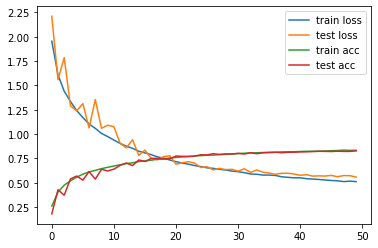

In [18]:
model = final_model_cifar_10()

In [24]:
# model.save('../models/b/model.h5')

### Load Model

In [11]:
model = load_model('../models/b/model.h5')

### Model Evaluation

In [12]:
def evaluate_final_model_metrics(model):
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print('Training Loss:\t', train_loss)
    print('Testing Loss:\t', test_loss)

    print('Training Acc:\t', train_acc)
    print('Testing Acc:\t', test_acc)

evaluate_final_model_metrics(model)

Training Loss:	 0.33310043811798096
Testing Loss:	 0.557822048664093
Training Acc:	 0.8980600237846375
Testing Acc:	 0.8270999789237976


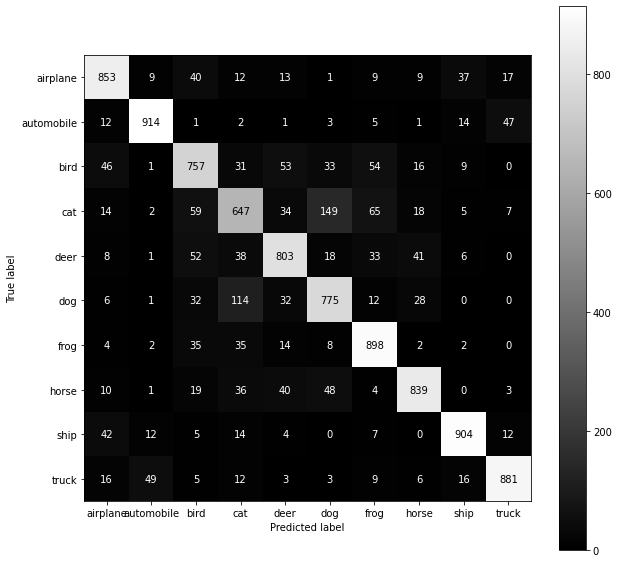

In [13]:
def evaluate_final_model_predictions(model):
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    y_true = y_test.argmax(axis=1)
    y_pred = model.predict(X_test).argmax(axis=1)

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=get_labels(), cmap='gray', ax=ax)

evaluate_final_model_predictions(model)

99% Confidence Accuracy: 0.9914561664190193
Actual: airplane     | Predicted: ship         | Frequency: 4
Actual: airplane     | Predicted: truck        | Frequency: 1
Actual: automobile   | Predicted: truck        | Frequency: 3
Actual: automobile   | Predicted: ship         | Frequency: 1
Actual: bird         | Predicted: frog         | Frequency: 2
Actual: cat          | Predicted: frog         | Frequency: 2
Actual: deer         | Predicted: frog         | Frequency: 2
Actual: deer         | Predicted: horse        | Frequency: 1
Actual: dog          | Predicted: horse        | Frequency: 1
Actual: ship         | Predicted: airplane     | Frequency: 2
Actual: truck        | Predicted: automobile   | Frequency: 4


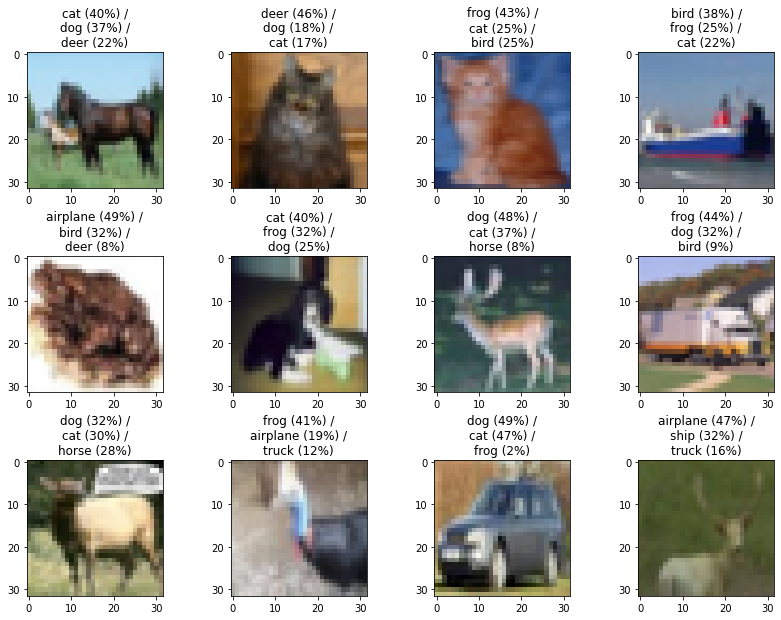

In [14]:
def evaluate_final_model_confidence(model):
    X_train, y_train, X_test, y_test = load_preprocessed_data()

    labels = get_labels()

    y_true = y_test.argmax(axis=1)
    
    y_pred_proba = model.predict(X_test)
    y_pred_highest_proba = y_pred_proba.max(axis=1).flatten()
    y_pred = y_pred_proba.argmax(axis=1)

    unsure = np.where(y_pred_highest_proba < 0.5)[0]
    sure = np.where(y_pred_highest_proba >= 0.99)[0]

    # Shows the actual accuracy rate of the model when it is at least 99% confident of its prediction
    print('99% Confidence Accuracy:', accuracy_score(y_true[sure], y_pred[sure]))

    wrong_class = {}

    for i in np.where(y_true[sure] != y_pred[sure])[0]:
        predicted = labels[y_pred[sure][i]]
        actual = labels[y_true[sure][i]]
        if (predicted, actual) in wrong_class:
            wrong_class[(predicted, actual)] += 1
        else:
            wrong_class[(predicted, actual)] = 1
    
    wrong_classes_sorted = sorted([(k[1], k[0], v) for k, v in wrong_class.items()], key=lambda x: (x[0], -x[2], x[1]))
    
    # Shows the frequency of its confident misclassifications
    for a, p, f in wrong_classes_sorted:
        print(f'Actual: {a:<12} | Predicted: {p:<12} | Frequency: {f:<}')

    # Shows the images which the model is unsure of,
    #   together with the alternative predictions
    #   and their corresponding confidence levels
    fig, ax = plt.subplots(3, 4, figsize=(14, 10))
    for j in range(12):
        ax[j // 4, j % 4].imshow(X_train[unsure[j]], cmap='gray')
        current_probs = y_pred_proba[unsure[j]]
        ax[j // 4, j % 4].set_title(' /\n'.join([f'{labels[current_probs.argsort()[::-1][i]]} ({np.sort(current_probs)[::-1][i] * 100:.0f}%)' for i in range(3)]))
    plt.subplots_adjust(hspace=0.5)
    plt.show()

evaluate_final_model_confidence(model)

## Conclusions

- From the confusion matrix, the model has trouble classifying cats and dogs correctly, often mistaking them for each other
- In general, the model predicts vehicles more correctly than animals
- Given the resolution of the images, this is a reasonable shortcoming
- Of the most confident predictions, the model always gets the general type correct (vehicle/animal)
- I also cannot deduce what the 5<sup>th</sup> image is
- The model predicts the ship image (top right) to be an animal, and is therefore wrong on all its top choices